In [1]:
import math
from typing import List, Tuple
from pathlib import Path
from copy import deepcopy

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from stego import FloatBinary, str_to_bits, bits_to_str

# Load the model

In [2]:
model = tf.keras.applications.ResNet50(include_top=True, weights="imagenet")

In [3]:
# model.summary()

# Inspect statistics for selected layer

In [4]:
layer_name = "conv5_block3_3_conv"

In [5]:
selected_layer_weights = model.get_layer(layer_name).weights[0].numpy().ravel()

## Basic statistics

In [6]:
nb_values = len(selected_layer_weights)
min_value = selected_layer_weights.min()
max_value = selected_layer_weights.max()
mean_value = selected_layer_weights.mean()
nb_really_small_values = (abs(selected_layer_weights) < 10e-4).sum()
nb_small_values = (abs(selected_layer_weights) < 10e-3).sum()
nb_negative_values = (selected_layer_weights < 0).sum()
nb_positive_values = (selected_layer_weights > 0).sum()

In [7]:
print(f"""Stats for {layer_name}
---
Min: {min_value}
Max: {max_value}
Mean: {mean_value}
---
Nb total values: {nb_values}
Nb values < 10e-4: {nb_really_small_values} - {nb_really_small_values/nb_values*100:.4f}%
Nb values < 10e-3: {nb_small_values} - {nb_small_values/nb_values*100:.4f}%
Nb negatives: {nb_negative_values} - {nb_negative_values/nb_values*100:.4f}%
Nb positives: {nb_positive_values} - {nb_positive_values/nb_values*100:.4f}%
""")

Stats for conv5_block3_3_conv
---
Min: -0.1346323937177658
Max: 0.29996708035469055
Mean: -0.0004575058992486447
---
Nb total values: 1048576
Nb values < 10e-4: 65063 - 6.2049%
Nb values < 10e-3: 583922 - 55.6871%
Nb negatives: 582856 - 55.5855%
Nb positives: 465720 - 44.4145%



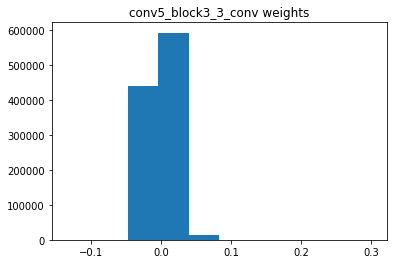

In [8]:
plt.hist(selected_layer_weights)
plt.title(f"{layer_name} weights");

## How much data can be hidden in the layer weights?

In [9]:
# Bits to use from the fraction of the float values (with bigger values you lose more precision)
bits_to_use: int = 16
assert bits_to_use <= 23, "Can't be bigger then 23 bits"

In [10]:
print(f"Mumber of params (float32 values): {len(selected_layer_weights)}")
print(f"Maximum storage in layer: {(len(selected_layer_weights) * bits_to_use) / 8000 / 1000:.2f} MB")

Mumber of params (float32 values): 1048576
Maximum storage in layer: 2.10 MB


# Hide a secret in the layer

## The secret

In [11]:
secret_to_hide = "I am Gabor and I would like to hide this message"
secret_bits = str_to_bits(secret_to_hide)

In [12]:
nb_vals_needed = math.ceil(len(secret_bits) / bits_to_use)

## Hide it

In [13]:
weights = deepcopy(model.get_layer(layer_name).weights[0].numpy())
weights_shape = weights.shape
# For easier processing...
weights = weights.ravel()

In [14]:
weights_modified = deepcopy(weights)
last_modified_index:int = -1

for i in range(nb_vals_needed):
    _from_index = i * bits_to_use
    _to_index = _from_index + bits_to_use
    bits_to_hide = secret_bits[_from_index:_to_index]
    bits_to_hide = list(map(bool, bits_to_hide))
    
    x = FloatBinary(weights[i])
    
    fraction_modified = list(x.fraction)
    fraction_modified[-bits_to_use:] = bits_to_hide
    x_modified = x.modify_clone(fraction=tuple(fraction_modified))
    
    weights_modified[i] = x_modified.v
    
    last_modified_index = i

In [15]:
# Debugging
nb_vals_needed, (np.abs((weights - weights_modified)) > 0).sum(), last_modified_index

(24, 24, 23)

# Let's test the network

## Dataset to test on

In [16]:
image_paths = list(map(str, Path("/tmp/images").glob("**/*.jpeg")))

In [17]:
len(image_paths)

566

In [18]:
batch_size = 1

In [19]:
def _read_image_from_path(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.uint8, expand_animations=False)
    image = tf.image.resize(image, (224, 224))
    return image

dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(_read_image_from_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Predictions

### Original weights predictions

In [20]:
model.get_layer(layer_name).set_weights([weights.reshape(weights_shape), model.get_layer(layer_name).get_weights()[1]])

In [21]:
preds_original = model.predict(dataset)

### Modified weights predictions

In [22]:
# Change layer weights - modified weights and the unchanged bias
model.get_layer(layer_name).set_weights([weights_modified.reshape(weights_shape), model.get_layer(layer_name).get_weights()[1]])

In [23]:
preds_modified = model.predict(dataset)

## Differences in predictions

### Raw prediction value comparisons (last layer output)

In [24]:
diff_abs = np.abs(preds_original - preds_modified).ravel()

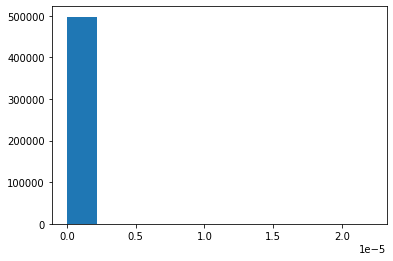

In [25]:
plt.hist(diff_abs[diff_abs > 0]);

In [26]:
print(f"Min abs difference: {diff_abs.min()}")
print(f"Max abs difference: {diff_abs.max()}")
print(f"Number of changed values: {(diff_abs > 0).sum()} - {(diff_abs > 0).sum()/len(diff_abs)*100:.4f}%")

Min abs difference: 0.0
Max abs difference: 2.2143125534057617e-05
Number of changed values: 497772 - 87.9456%


### Change in predicted labels

In [27]:
nb_changed_pred_labels = ((np.argmax(preds_original, 0) - np.argmax(preds_modified, 0)) > 0).sum()

In [28]:
print(f"Changed number of predictions: {nb_changed_pred_labels}")

Changed number of predictions: 0


# Recover the secret

In [29]:
hidden_data: List[bool] = []

for i in range(last_modified_index+1):
    x = FloatBinary(weights_modified[i])
    hidden_bits = x.fraction[-bits_to_use:]
    hidden_data.extend(hidden_bits)

In [30]:
recovered_message: str = bits_to_str(list(map(int, hidden_data)))

In [31]:
print(f"Recovered string:\n'{recovered_message}'")

Recovered string:
'I am Gabor and I would like to hide this message'


In [32]:
assert recovered_message == secret_to_hide, "Recovered message is not the same as the original one"